In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import math
from scipy.linalg import circulant
from models import HopfieldNetwork, TSP, CompleteGraph

## Steps to reproduce hopfield tsp paper
1. Encode TSP into Hopfield Network to get energy function
2. Apply Simulated Annealing to check for correctness of the implementation

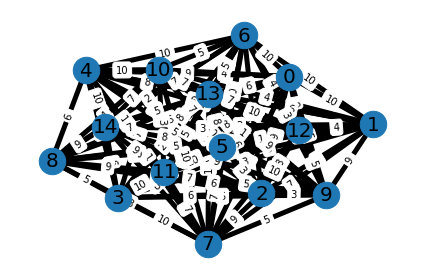

In [2]:
# Creating an example graph
G = CompleteGraph(15)
G.draw_graph()

In [3]:
#Creating a TSP instance and encode it into a Hopfield Network
graph = G.get_graph()
tsp = TSP.from_graph(graph)
hopfield = HopfieldNetwork(tsp.T, tsp.I, tsp.offset)

In [4]:
#Get the energy using the Christofides algorithm to compare with our results
solution = tsp.get_encoding(nx.approximation.christofides(graph)[:-1])
res = hopfield.compute_energy(solution, debug=False)
print("Energy of optimal solution:", res)
print(tsp.interpret(solution))
print("Actual best tour length (HEURISTIC!!):",tsp.get_cost(solution))

Energy of optimal solution: -4460.0
[ 0.  5. 12. 11. 10.  9.  4.  7. 13.  3. 14.  1.  8.  2.  6.]
Actual best tour length (HEURISTIC!!): 40


### Solving it with simulated annealing

In [5]:
from scipy.optimize import dual_annealing

In [6]:
l_bound = [0] * tsp.n**2
u_bound = [1] * tsp.n**2
REPEATS = 5
print("Repeat:", 1)
solution = dual_annealing(hopfield.compute_energy, bounds=list(zip(l_bound, u_bound)), maxiter=100)
for i in range(1, REPEATS):
    print("Repeat:", i+1)
    tmp = dual_annealing(hopfield.compute_energy, bounds=list(zip(l_bound, u_bound)), maxiter=100)
    if tmp.fun < solution.fun:
        solution = tmp

Repeat: 1
Repeat: 2
Repeat: 3
Repeat: 4
Repeat: 5


In [7]:
print(tsp.interpret(solution.x))
print(solution)
print("BEST ENERGY VALUE (without offset):", hopfield.compute_energy(solution.x, debug=True))
print("ACTUAL TOUR LENGTH:", tsp.get_cost(solution.x))

[8. 4. 1. 5. 7. 6. 0. 2. 3. 9.]
 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: -1963.1125
       x: [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
     nit: 100
    nfev: 32727
    njev: 126
    nhev: 0
First term (inhibitory row connections): 0.0
First term (inhibitory column connections): 0.0
First term (Data term): 78.0
First term (global inhibitory connections): 4000.0
Second term (Magnetic Field term): 4000.0
Energy (with constant term): 39.0
Constant term: 2000
If V is a valid tour then the energy with the constant term is equal to the tour length!
BEST ENERGY VALUE (without offset): -1961.0
ACTUAL TOUR LENGTH: 39


In [12]:
import gurobipy as gp
from gurobipy import Model, GRB, QuadExpr
options = {}
with gp.Env(params=options) as env, gp.Model(env=env) as model:
    print(env)
    # Formulate problem
    problem = TSP.from_graph(graph, A=500, B=500, C=200, D=1)
    # Define the interaction matrix (Q) and field vector (c)
    Q = problem.T[-2] # Interaction matrix
    c = problem.I # Field vector
    
    # Create a new Gurobi model
    model = Model("Qua")
    
    # Add binary variables
    n = Q.shape[0]
    var = [model.addVar(vtype=GRB.BINARY, name=f"x{i}") for i in range(n)]
    
    # Set up the quadratic objective
    objective = QuadExpr()
    
    # Add quadratic terms from Q
    for i in range(n):
        for j in range(n):
            if Q[i, j] != 0:
                objective.add(-0.5*Q[i, j] * var[i] * var[j])
    
    # Add linear terms from c
    for i in range(n):
        if c[i] != 0:
            objective.add(-c[i] * var[i])
    
            
    objective.addConstant(problem.offset)
    
    # Set the objective
    model.setObjective(objective, GRB.MINIMIZE)
    model.setParam("Presolve", 2)
    model.setParam("PreSparsify", 1)
    model.setParam("MIPFocus", 3)
    model.setParam("PreQLinearize", 0)
    model.setParam("DegenMoves", 0)
    
    # Optimize the model
    model.optimize()
    
    
    gurobi_solution = []
    # Display results
    if model.status == GRB.OPTIMAL:
        print("Optimal value:", model.objVal)
        for v in var:
            print(f"{v.varName} = {v.x}")
            gurobi_solution.append(v.x)
    else:
        print("No optimal solution found.")
    
        
    print(problem.interpret(np.array(gurobi_solution)))
    print(hopfield.compute_energy(np.array(gurobi_solution), debug=True))

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2595968
Academic license 2595968 - for non-commercial use only - registered to s0___@uni-bonn.de
<gurobipy.Env, Parameter changes: WLSAccessID=(user-defined), WLSSecret=(user-defined), LicenseID=2595968>
Set parameter Presolve to value 2
Set parameter PreSparsify to value 1
Set parameter MIPFocus to value 3
Set parameter PreQLinearize to value 0
Set parameter DegenMoves to value 0
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.1.0 24B83)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
DegenMoves  0
MIPFocus  3
PreQLinearize  0
Presolve  2
PreSparsify  1

Academic license 2595968 - for non-commercial use only - registered to s0___@uni-bonn.de
Optimize a model with 0 rows, 225 columns and 0 nonzeros
Model fingerprint: 0x1d1c38bf
Model has 25425 quadratic objective terms
Variable types: 0 continuous, 225 inte

ValueError: cannot reshape array of size 0 into shape (15,15)